In [108]:
import itertools
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import Tensor
from torch.nn import Module, Linear
import torch.nn.functional as F
from torch.optim import SGD
from torch import special
from tqdm import tqdm

## Load data

In [135]:
alphabet = pd.read_csv("../ignore/alphabet.csv", index_col=0)
data = pd.read_csv("../ignore/translation_train.csv", index_col=0, dtype=str)
olga_marginal = pd.read_csv("../ignore/average_olga_vector.csv", header=None).values.squeeze()

olga_marginal = torch.tensor(olga_marginal, dtype=torch.float32)

In [136]:
alphabet

,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
Letter,0,1,0,1,0,1,1,0,0,0,1,1,0,1,0,0,0,0,1,1


In [137]:
data.head()

,CDR3A,CDR3B,epitope,Assays,translation_CDR3A,translation_CDR3B,translation_epitope
0,EGVND,SGTGI,DRKSD,multimer/tetramer,11010,01010,00000
1,STGAN,GRGGY,GGALQ,"dextramer-sort,dextramer-sort",00101,10111,11001
2,STGAN,GRGGY,GGALQ,"dextramer-sort,dextramer-sort",00101,10111,11001
3,LDSNY,AGEPY,GGALQ,"dextramer-sort,dextramer-sort",00011,01101,11001
4,LDSNY,AGEPY,GGALQ,"dextramer-sort,dextramer-sort",00011,01101,11001


In [138]:
olga_marginal

tensor([0.3483, 0.4406, 0.5417, 0.5723, 0.5527, 0.3177, 0.3935, 0.4306, 0.4339,
        0.4961])

In [40]:
def compute_epitope_priors(epi_length: int, num_ones_in_alphabet: int) -> dict:
    """
    Compute the prior probability of each epitope of length `epi_length` given the alphabet.
    """
    prob_one = num_ones_in_alphabet / 20
    prob_zero = 1 - prob_one

    possible_epitopes = [tuple(prod) for prod in itertools.product([0,1], repeat=epi_length)]
    
    def compute_prob(epitope: tuple) -> float:
        return prob_one ** epitope.count(1) * prob_zero ** epitope.count(0)
    
    return {epitope: compute_prob(epitope) for epitope in possible_epitopes}

In [50]:
num_ones_in_alphabet = int(alphabet.loc["Letter"].sum())
epitope_priors = compute_epitope_priors(5, num_ones_in_alphabet)

In [94]:
# Turn translated sequences into torch tensors
def map_zero_one_string_to_tensor(zero_one_string: str) -> Tensor:
    return torch.tensor([float(char) for char in zero_one_string])

cdr3a_tensor = torch.stack(data["translation_CDR3A"].map(map_zero_one_string_to_tensor).tolist())
cdr3b_tensor = torch.stack(data["translation_CDR3B"].map(map_zero_one_string_to_tensor).tolist())
tcr_tensor = torch.concatenate((cdr3a_tensor, cdr3b_tensor), dim=1)
epitope_tensor = torch.stack(data["translation_epitope"].map(map_zero_one_string_to_tensor).tolist())

## Define Dumpy

In [79]:
class Dumpy(Module):
    def __init__(self, in_features: int, out_features: int):
        super(Dumpy, self).__init__()
        self.linear = Linear(in_features=in_features, out_features=out_features, bias=True)
    
    def forward(self, x):
        x = self.linear(x)
        return special.expit(x)

    def forward_logit(self, x):
        return self.linear(x)

## Train

Here the hyperparameter **lambda** (`lmb` in code) is the relative weighting of the **marginal loss term** (how close the model's marginal TCR distribution is to the target OLGA marginal) compared to the **conditional loss term** (how well the model can predict TCR given epitope).
I execute 10 different training runs with varying lambda, to see which lambda we like the trade-off of most.
This trade-off is evaluated later down in the notebook.

In [127]:
def train(epitope_tensor: Tensor, tcr_tensor: Tensor, epitope_priors: dict[tuple, float], target_marginal: Tensor, lmb: float, epochs: int = 5000):
    model = Dumpy(5, 10)
    optimizer = SGD(model.parameters(), lr=1)

    losses = []

    for _ in tqdm(range(epochs)):
        optimizer.zero_grad()

        model_output = model.forward_logit(epitope_tensor)
        model_marginal = compute_model_marginal(model, epitope_priors)
        conditional_loss = F.binary_cross_entropy_with_logits(model_output, tcr_tensor)
        marginal_loss = F.binary_cross_entropy(model_marginal, target_marginal.unsqueeze(0))
        loss = conditional_loss + lmb * marginal_loss

        losses.append(loss.item())

        loss.backward()
        optimizer.step()

    print(f"Lambda: {lmb}")
    print(f"Conditional loss: {conditional_loss.item()}")
    print(f"Marginal loss: {marginal_loss.item()}")

    plt.figure(figsize=(3,1))
    plt.plot(losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.xticks([])
    plt.yticks([])
    plt.show()

    return model, conditional_loss.item(), marginal_loss.item()

def compute_model_marginal(model: Module, epitope_priors: dict[tuple, float]) -> Tensor:
    weighted_conditionals = [model.forward(torch.tensor(epitope, dtype=torch.float32).unsqueeze(0)) * epitope_prior for epitope, epitope_prior in epitope_priors.items()]
    return torch.sum(torch.stack(weighted_conditionals, dim=0), dim=0)

def compute_average_data_likelihood(model: Module, epitope_tensor: Tensor, tcr_tensor: Tensor) -> float:
    model_output = model.forward_logit(epitope_tensor)
    return F.binary_cross_entropy_with_logits(model_output, tcr_tensor).item()

100%|██████████| 5000/5000 [00:11<00:00, 425.46it/s]

Lambda: 0.10000000149011612
Conditional loss: 0.670039713382721
Marginal loss: 0.6769285202026367


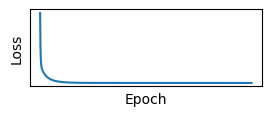

100%|██████████| 5000/5000 [00:11<00:00, 422.82it/s]

Lambda: 0.1668100506067276
Conditional loss: 0.6701127886772156
Marginal loss: 0.6763703227043152


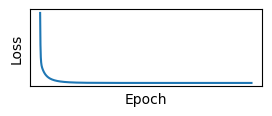

100%|██████████| 5000/5000 [00:12<00:00, 412.44it/s]

Lambda: 0.2782559394836426
Conditional loss: 0.6702274084091187
Marginal loss: 0.6758408546447754


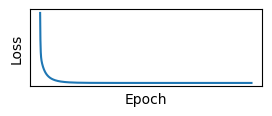

100%|██████████| 5000/5000 [00:11<00:00, 422.57it/s]

Lambda: 0.46415889263153076
Conditional loss: 0.6703765988349915
Marginal loss: 0.6754242181777954


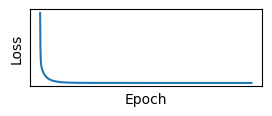

100%|██████████| 5000/5000 [00:11<00:00, 426.35it/s]


Lambda: 0.7742636799812317
Conditional loss: 0.6705380082130432
Marginal loss: 0.6751519441604614


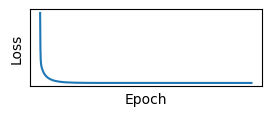

100%|██████████| 5000/5000 [00:11<00:00, 424.58it/s]

Lambda: 1.2915496826171875
Conditional loss: 0.6706857681274414
Marginal loss: 0.6750014424324036


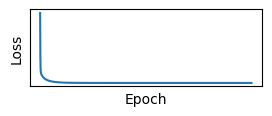

100%|██████████| 5000/5000 [00:11<00:00, 424.61it/s]

Lambda: 2.1544346809387207
Conditional loss: 0.6708043217658997
Marginal loss: 0.6749286651611328


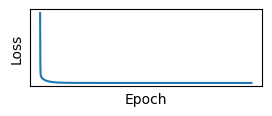

100%|██████████| 5000/5000 [00:11<00:00, 425.60it/s]

Lambda: 3.59381365776062
Conditional loss: 0.6708903908729553
Marginal loss: 0.6748969554901123


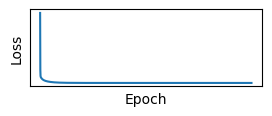

100%|██████████| 5000/5000 [00:11<00:00, 425.23it/s]

Lambda: 5.994842529296875
Conditional loss: 0.6709486842155457
Marginal loss: 0.674884021282196


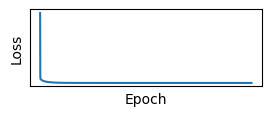

100%|██████████| 5000/5000 [00:11<00:00, 425.69it/s]

Lambda: 10.0
Conditional loss: 0.6709864139556885
Marginal loss: 0.6748790740966797


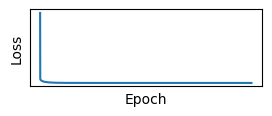

In [128]:
lmbs = torch.logspace(-1, 1, 10)
results = {lmb.item(): train(epitope_tensor, tcr_tensor, epitope_priors, olga_marginal, lmb) for lmb in lmbs}

## Inspect different pareto-optimal models

In [194]:
conditional_losses = [result[1] for result in results.values()]
marginal_losses = [result[2] for result in results.values()]
results_table = pd.DataFrame({"Lambda": results.keys(), "Conditional loss": conditional_losses, "Marginal loss": marginal_losses})

In [195]:
results_table

,Lambda,Conditional loss,Marginal loss
0,0.100000,0.670040,0.676929
1,0.166810,0.670113,0.676370
2,0.278256,0.670227,0.675841
3,0.464159,0.670377,0.675424
4,0.774264,0.670538,0.675152
5,1.291550,0.670686,0.675001
6,2.154435,0.670804,0.674929
7,3.593814,0.670890,0.674897
8,5.994843,0.670949,0.674884
9,10.000000,0.670986,0.674879


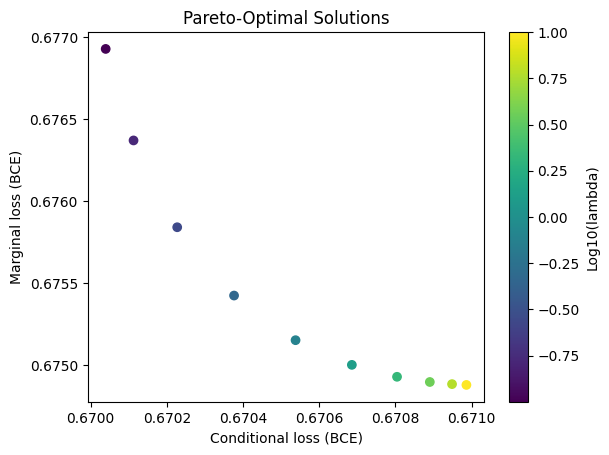

In [196]:
plt.figure()

scatter = plt.scatter(results_table["Conditional loss"], results_table["Marginal loss"], c=np.log10(results_table["Lambda"]))
plt.colorbar(scatter, label="Log10(lambda)")

plt.title("Pareto-Optimal Solutions")
plt.xlabel("Conditional loss (BCE)")
plt.ylabel("Marginal loss (BCE)")

plt.show()

## Make joint model

The `Dumpy` model on its own can only compute the conditional distribution of TCRs given epitope.
A combination of a Dumpy instance and a prior distribution over the epitope hypercube gives you the full joint distribution.
I implement a class below which concretises this idea.

In [186]:
class DumpyJoint:
    def __init__(self, dumpy_model: Dumpy, epitope_priors: dict[tuple, float]):
        self.dumpy_model = dumpy_model
        self.tcr_dimensionality = dumpy_model.linear.out_features
        self.epitope_dimensionality = dumpy_model.linear.in_features
        self.epitope_priors = epitope_priors

    @torch.no_grad()
    def joint(self, tcrs: Tensor, epitopes: Tensor) -> Tensor:
        """
        Compute a matrix of joint probabilities of TCRs and epitopes.
        The shape of the output matrix is (n_tcrs, n_epitopes).
        That is, this function computes the probability of all pairs between input TCRs and epitopes.
        """
        tcr_distributions = self.dumpy_model.forward(epitopes)
        conditional_tcr_probs = self._get_likelihood(tcrs, tcr_distributions)
        marginal_epitope_probs = self._get_epitope_marginals(epitopes)
        return marginal_epitope_probs.unsqueeze(0) * conditional_tcr_probs

    def _get_likelihood(self, target: Tensor, distribution: Tensor) -> Tensor:
        distribution = distribution.unsqueeze(0)
        target = target.unsqueeze(1)
        return torch.prod(target * distribution + (1 - target) * (1 - distribution), dim=-1)

    def _get_epitope_marginals(self, epitopes: Tensor) -> Tensor:
        epitopes_as_tuples = [tuple(epitope.to(int).tolist()) for epitope in epitopes]
        marginals = [self.epitope_priors[epitope] for epitope in epitopes_as_tuples]
        return torch.tensor(marginals)

In [187]:
joint_model = DumpyJoint(Dumpy(5, 10), epitope_priors)
mini_tcr_tensor = tcr_tensor[:3]
mini_epitope_tensor = epitope_tensor[:3]

In [197]:
all_possible_tcrs = torch.stack([torch.tensor(prod, dtype=torch.float32) for prod in itertools.product([0,1], repeat=10)])
all_possible_epitopes = torch.stack([torch.tensor(epitope, dtype=torch.float32) for epitope in epitope_priors.keys()])
joint_model.joint(all_possible_tcrs, all_possible_epitopes).sum() # Should be 1

tensor(1.)